🎨 STARTING FELZENSZWALB 2D AUDIO SEGMENTATION
🎵 LOADING AUDIO: clips/fossil.mp3
   ⏱️  Duration: 46.97s, Sample Rate: 48000Hz
📊 COMPUTING STFT...
   🔧 n_fft=2048, hop_length=512
   📏 Spectrogram shape: 1025 freq × 4404 time
🎨 PREPARING IMAGE FOR SEGMENTATION...
   🖼️  Image range: 0-255 (8-bit grayscale)
🧩 RUNNING FELZENSZWALB SEGMENTATION...
   ⚙️  scale=150, sigma=3, min_size=20
   🎯 Found 904 initial segments (labels)
🔍 EXTRACTING 2D SHAPES (one per label)...
   🎵 rms: 0.03
   🎵 Shape  1: 4.52s ×  60bins, energy=5.2e-02 → felzen_shape_001_t425_f60.wav
   🎵 rms: 0.01
   🎵 Shape  2: 1.21s ×  22bins, energy=2.3e-03 → felzen_shape_002_t114_f22.wav
   🎵 rms: 0.04
   🎵 Shape  3: 7.46s × 101bins, energy=1.2e-01 → felzen_shape_003_t700_f101.wav
   🎵 rms: 0.01
   🎵 Shape  4: 0.80s ×   8bins, energy=1.3e-03 → felzen_shape_004_t76_f8.wav
   🎵 rms: 0.05
   🎵 Shape  5: 6.03s ×  66bins, energy=1.0e-01 → felzen_shape_005_t566_f66.wav
   🎵 rms: 0.01
   🎵 Shape  6: 1.24s ×  33bins, energy=3.8e-03 → 

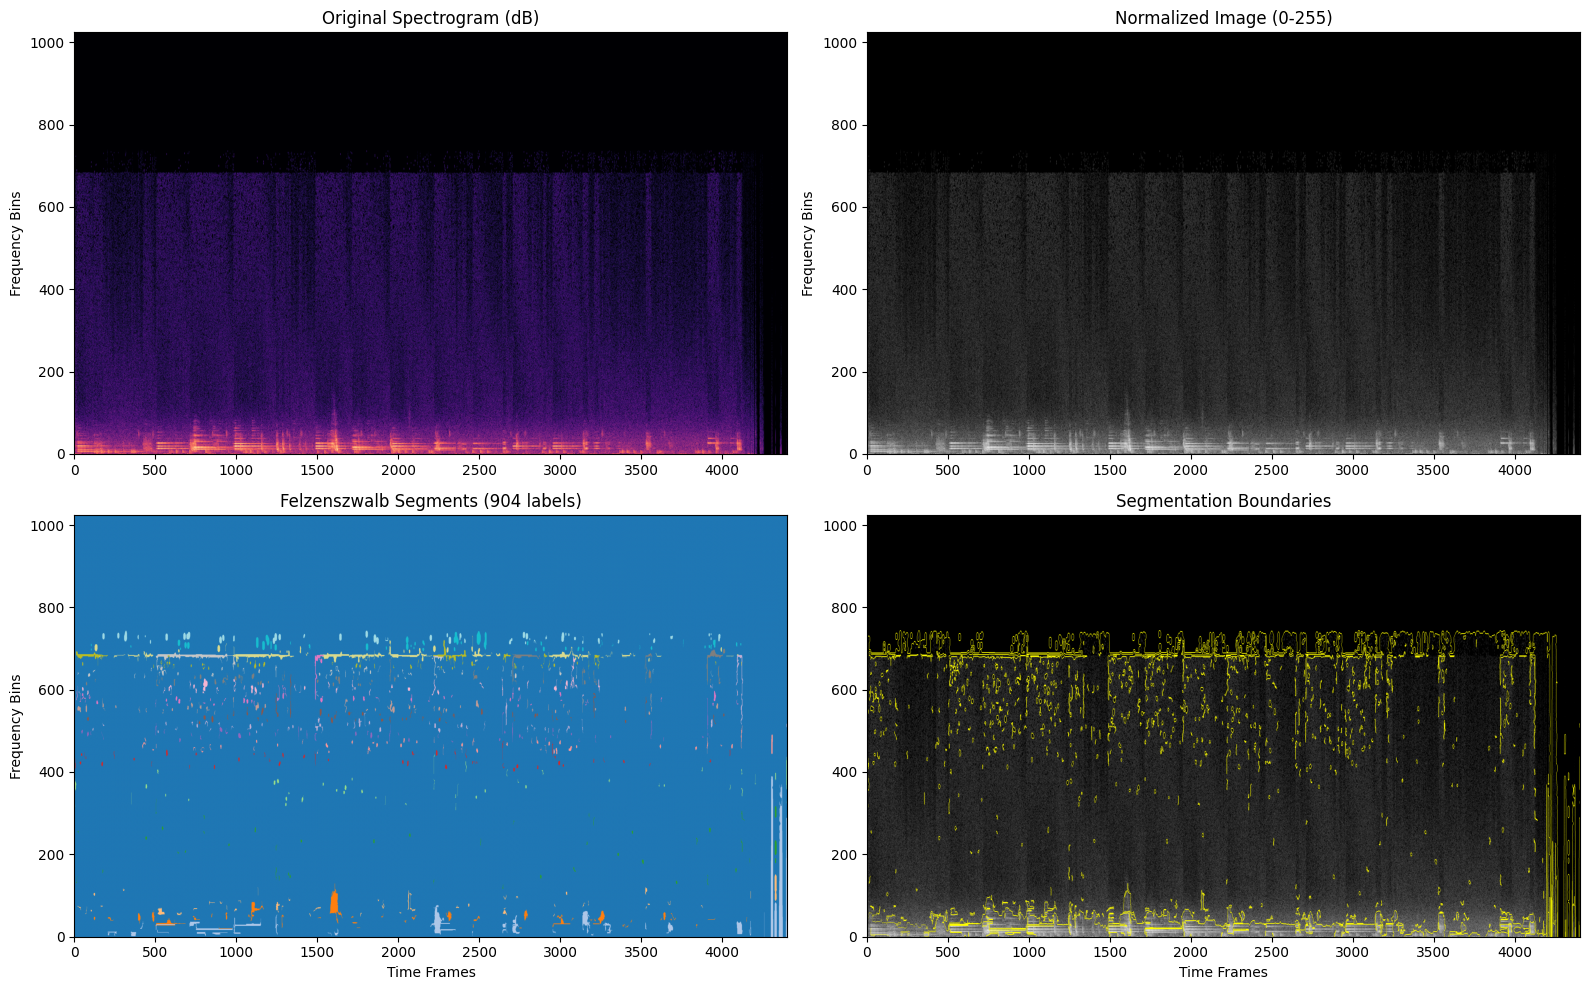


📊 SUMMARY:
   ⏱️  Processing time: 177.86s
   🧩 Total labels found: 904
   🧩 Label regions processed (kept + filtered): 12
   ❌ Filtered out: 2
      └─ By time (< 0.5s duration): 2
      └─ By time (empty): 0
      └─ By energy (< 1.0e-03 ratio): 0
      └─ By area (< 200 pixels): 0
   ✅ Audio chunks saved: 10
   📁 Output directory: chunks_detailed_fossil/
   🎵 Average chunk duration: 4.01s


In [10]:
import numpy as np
import librosa
import soundfile as sf
import os
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb, mark_boundaries
from skimage.util import img_as_ubyte
import time

def split_audio_felzenszwalb_2d(
    audio_path,
    output_dir="chunks_detailed_{song_path.split('/')[-1].split('.')[0]}",
    n_fft=2048,
    hop_length=512,
    scale=150,
    sigma=3,
    min_size=20,
    min_area_pixels=200,
    min_time_seconds=0.1,
    min_energy_ratio=1e-4,
    max_shapes=None,
):
    """
    🎨 TRUE 2D FELZENSZWALB AUDIO SEGMENTATION (no connected-components)

    This function treats audio spectrograms like images and segments them into irregular 2D shapes.
    Unlike traditional time-based chunking, this extracts spectral "objects" from music.

    HOW IT WORKS:
    1) Compute STFT (frequency × time matrix)
    2) Treat magnitude spectrogram as a grayscale image
    3) Run Felzenszwalb segmentation to get label regions
    4) For EACH LABEL (as a whole), reconstruct its audio by masking the original STFT
    5) Save each label’s audio as its own file

    PARAMETERS:
    - n_fft: Frequency resolution (higher = more freq detail, less time detail)
    - hop_length: Time resolution (lower = more time detail, less freq detail)
    - scale/sigma/min_size: Felzenszwalb controls
    - min_area_pixels / min_time_seconds / min_energy_ratio: filters to skip tiny/short/quiet labels
    """
    start_time = time.time()
    os.makedirs(output_dir, exist_ok=True)

    print(f"🎵 LOADING AUDIO: {audio_path}")

    # 1) Load audio
    y, sr = librosa.load(audio_path, sr=None)
    duration = len(y) / sr
    print(f"   ⏱️  Duration: {duration:.2f}s, Sample Rate: {sr}Hz")

    # 2) Complex STFT and magnitude
    print(f"📊 COMPUTING STFT...")
    print(f"   🔧 n_fft={n_fft}, hop_length={hop_length}")
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window="hann", center=True)
    S = np.abs(D)  # (freq_bins, time_frames)
    freq_bins, time_frames = S.shape
    print(f"   📏 Spectrogram shape: {freq_bins} freq × {time_frames} time")

    # 3) Log scale + normalize to 0..255 for segmentation
    print(f"🎨 PREPARING IMAGE FOR SEGMENTATION...")
    S_db = librosa.amplitude_to_db(S + 1e-12, ref=np.max)
    S_db_norm = (S_db - S_db.min()) / max(1e-12, (S_db.max() - S_db.min()))
    img = img_as_ubyte(S_db_norm)  # 2D grayscale image
    print(f"   🖼️  Image range: {img.min()}-{img.max()} (8-bit grayscale)")

    # 4) Felzenszwalb segmentation on 2D spectrogram image
    print(f"🧩 RUNNING FELZENSZWALB SEGMENTATION...")
    print(f"   ⚙️  scale={scale}, sigma={sigma}, min_size={min_size}")
    segments = felzenszwalb(img, scale=scale, sigma=sigma, min_size=min_size)
    unique_labels = np.unique(segments)
    print(f"   🎯 Found {len(unique_labels)} initial segments (labels)")

    # 5) Process each label as a single region (no CC)
    print(f"🔍 EXTRACTING 2D SHAPES (one per label)...")
    total_energy = float(S.sum()) + 1e-12
    T = S.shape[1]
    times = librosa.frames_to_time(np.arange(T), sr=sr, hop_length=hop_length)

    saved_paths = []
    shape_index = 0
    filtered_shapes = 0
    filtered_by_area = 0
    filtered_by_energy = 0
    filtered_by_time = 0
    filtered_by_time_empty = 0
    kept_segments = []

    for _, label in enumerate(unique_labels):
        chunk_mask = (segments == label)          # use the label mask directly

        # Filter 1: Time span too short
        time_mask = np.any(chunk_mask, axis=0)
        min_time_frames = int(min_time_seconds * sr / hop_length)
        if time_mask.sum() < min_time_frames:
            filtered_shapes += 1
            filtered_by_time += 1
            continue

        # Filter 2: Energy too low
        energy = float(S[chunk_mask].sum())
        energy_ratio = energy / total_energy
        if energy_ratio < min_energy_ratio:
            filtered_shapes += 1
            filtered_by_energy += 1
            continue

        # Filter 3: Area too small  
        area = int(chunk_mask.sum())
        if area < min_area_pixels:
            filtered_shapes += 1
            filtered_by_area += 1
            continue

        # Calculate shape boundaries
        t0 = int(np.argmax(time_mask))
        t1 = int(len(time_mask) - np.argmax(time_mask[::-1]) - 1)
        freq_mask = np.any(chunk_mask, axis=1)
        f0 = int(np.argmax(freq_mask))
        f1 = int(len(freq_mask) - np.argmax(freq_mask[::-1]) - 1)

        time_span = times[t1] - times[t0] if t1 > t0 else 0
        freq_span = f1 - f0 + 1

        # 🎵 RECONSTRUCT AUDIO: Mask the complex STFT with this label region
        D_masked = D * chunk_mask.astype(D.dtype)
        y_rec = librosa.istft(D_masked, hop_length=hop_length, length=len(y))

        # Slice to the time span of this shape for a concise chunk
        start_samp = int(times[t0] * sr)
        end_samp = min(len(y), int(times[min(t1 + 1, T - 1)] * sr))
        y_seg = y_rec[start_samp:end_samp]
        if y_seg.size == 0:
            filtered_shapes += 1
            filtered_by_time_empty += 1
            continue

        # # # Normalize to avoid clipping
        # peak = np.max(np.abs(y_seg))
        # if peak > 0:
        #     y_seg = 0.98 * y_seg / peak

        # Simple RMS loudness normalization
        # target_rms = 0.1  # target average amplitude (~-20 dBFS, adjust as needed)
        # rms = np.sqrt(np.mean(y_seg**2) + 1e-12)
        # if rms > 0:
        #     y_seg = y_seg * (target_rms / rms)
        
        # Normalize to avoid clipping
        peak = np.max(np.abs(y_seg))      
        if peak > 1.0: 
            y_seg = 0.98 * y_seg / peak
        
        shape_index += 1
        filename = f"felzen_shape_{shape_index:03d}_t{(t1 - t0 + 1)}_f{freq_span}.wav"
        out_path = os.path.join(output_dir, filename)
        sf.write(out_path, y_seg, sr)
        saved_paths.append(out_path)
        print(f"   🎵 rms: {np.sqrt(np.mean(y_seg**2)):.2f}")

        kept_segments.append({
            "idx": int(shape_index - 1),
            "label": int(label),
            "t0_frame": int(t0),
            "t1_frame": int(t1),
            "t0_sec": float(times[t0]),
            "t1_sec": float(times[min(t1 + 1, T - 1)]),
            "f0_bin": int(f0),
            "f1_bin": int(f1),
            "freq_span": int(freq_span),
            "time_span_sec": float(time_span),
            "energy_ratio": float(energy_ratio),
            "path": out_path,
        })

        print(f"   🎵 Shape {shape_index:2d}: {time_span:.2f}s × {freq_span:3d}bins, energy={energy_ratio:.1e} → {filename}")

        if max_shapes is not None and shape_index >= max_shapes:
            break

    # 6) Create and display visualization
    print(f"📊 CREATING VISUALIZATIONS...")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Original spectrogram
    axes[0,0].imshow(S_db, aspect='auto', origin='lower', cmap='magma')
    axes[0,0].set_title('Original Spectrogram (dB)')
    axes[0,0].set_ylabel('Frequency Bins')

    # Normalized image for segmentation
    axes[0,1].imshow(img, aspect='auto', origin='lower', cmap='gray')
    axes[0,1].set_title('Normalized Image (0-255)')
    axes[0,1].set_ylabel('Frequency Bins')

    # Segmentation labels
    axes[1,0].imshow(segments, aspect='auto', origin='lower', cmap='tab20')
    axes[1,0].set_title(f'Felzenszwalb Segments ({len(unique_labels)} labels)')
    axes[1,0].set_xlabel('Time Frames')
    axes[1,0].set_ylabel('Frequency Bins')

    # Boundaries overlay
    boundary_img = mark_boundaries(np.dstack([S_db_norm]*3), segments)
    axes[1,1].imshow(boundary_img, aspect='auto', origin='lower')
    axes[1,1].set_title('Segmentation Boundaries')
    axes[1,1].set_xlabel('Time Frames')

    plt.tight_layout()
    viz_path = os.path.join(output_dir, "felzenszwalb_analysis.png")
    plt.savefig(viz_path, dpi=160, bbox_inches='tight')
    print(f"   💾 Saved visualization: {viz_path}")
    plt.show()

    # Summary statistics
    total_time = time.time() - start_time
    print(f"\n📊 SUMMARY:")
    print(f"   ⏱️  Processing time: {total_time:.2f}s")
    print(f"   🧩 Total labels found: {len(unique_labels)}")
    print(f"   🧩 Label regions processed (kept + filtered): {shape_index + filtered_shapes}")
    print(f"   ❌ Filtered out: {filtered_shapes}")
    print(f"      └─ By time (< {min_time_seconds}s duration): {filtered_by_time}")
    print(f"      └─ By time (empty): {filtered_by_time_empty}")
    print(f"      └─ By energy (< {min_energy_ratio:.1e} ratio): {filtered_by_energy}")
    print(f"      └─ By area (< {min_area_pixels} pixels): {filtered_by_area}")
    print(f"   ✅ Audio chunks saved: {shape_index}")
    print(f"   📁 Output directory: {output_dir}/")
    if saved_paths:
        print(f"   🎵 Average chunk duration: {np.mean([len(sf.read(p)[0])/sr for p in saved_paths[:5]]):.2f}s")
    else:
        print(f"   🎵 Average chunk duration: n/a")

    return saved_paths, kept_segments

# 🚀 RUN THE SEGMENTATION
print("🎨 STARTING FELZENSZWALB 2D AUDIO SEGMENTATION")
print("=" * 60)
song_path = "clips/fossil.mp3"
shapes, kept_segments = split_audio_felzenszwalb_2d(
    song_path,
    output_dir=f"chunks_detailed_{song_path.split('/')[-1].split('.')[0]}",
    scale=150,      # Lower = more segments
    sigma=3,        # Lower = sharper boundaries
    min_size=20,    # Larger = fewer tiny segments
    max_shapes=10,  # Limit output for testing
    min_area_pixels=200,
    min_time_seconds=0.5,  # Minimum duration in seconds
    min_energy_ratio=1e-3
)

(217600,)
0.032082617
(58368,)


/Users/mykqs/dev/fuites-anarchive/packages/compost/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=912
  warnings.warn(
/Users/mykqs/dev/fuites-anarchive/packages/compost/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=456
  warnings.warn(


0.04718189
(358400,)
0.06383242
(38912,)


/Users/mykqs/dev/fuites-anarchive/packages/compost/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=608
  warnings.warn(
/Users/mykqs/dev/fuites-anarchive/packages/compost/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=304
  warnings.warn(


0.10644941
(289793,)
0.062491458
(59903,)


/Users/mykqs/dev/fuites-anarchive/packages/compost/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=936
  warnings.warn(
/Users/mykqs/dev/fuites-anarchive/packages/compost/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=468
  warnings.warn(


0.08147012
(26112,)


/Users/mykqs/dev/fuites-anarchive/packages/compost/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=816
  warnings.warn(
/Users/mykqs/dev/fuites-anarchive/packages/compost/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=408
  warnings.warn(
/Users/mykqs/dev/fuites-anarchive/packages/compost/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=204
  warnings.warn(


0.097924896
(231424,)
0.064502545
(119808,)
0.048553552
(152064,)
0.05843475


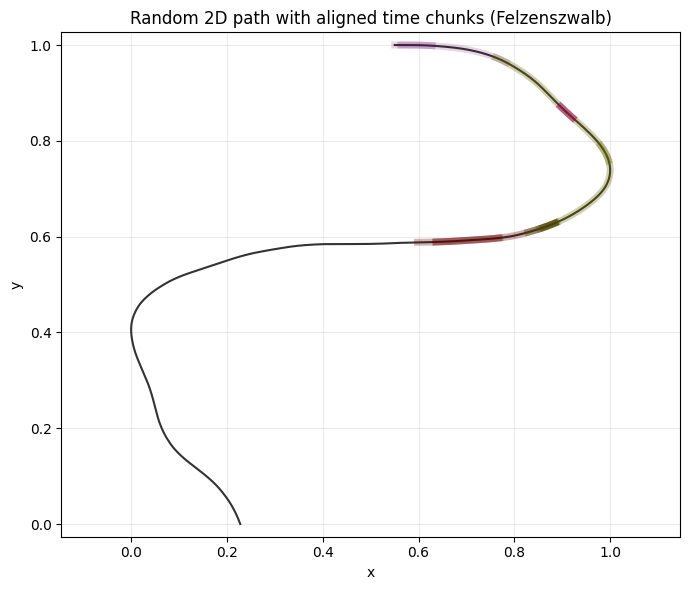

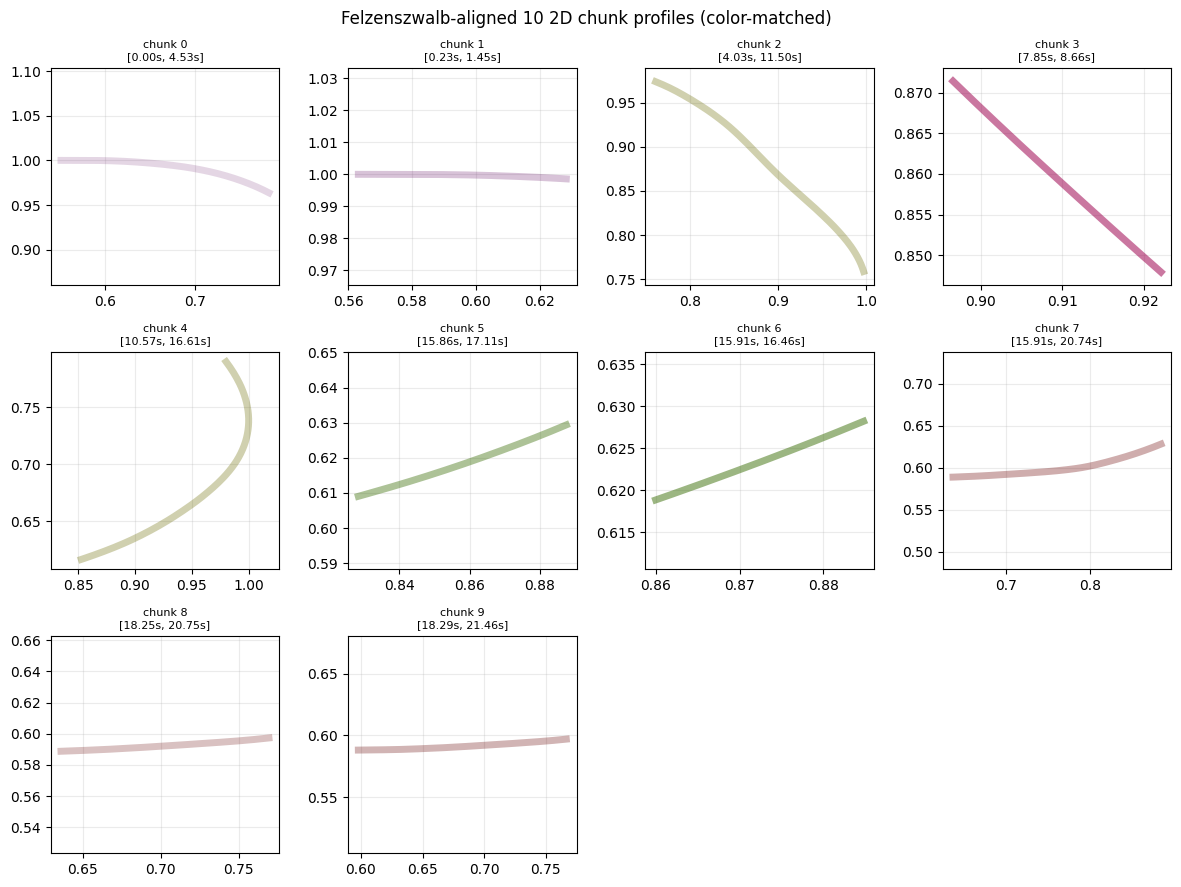

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import colorsys

# Random 2D path over the clip timeline → chunks aligned to Felzenszwalb windows if available
rng = np.random.default_rng(2)

# Parameters
clip_path = song_path
clip_duration_sec = (len(y) / sr) if ('y' in globals() and 'sr' in globals()) else librosa.get_duration(path=clip_path)
points_per_second = 100
resampled_points_per_chunk = 128

# Build smooth randomized 2D path (x(t), y(t)) over [0, clip_duration]
T = np.linspace(0.0, clip_duration_sec, max(3, int(np.ceil(clip_duration_sec * points_per_second))), endpoint=True)
num_points = T.size
if num_points < 3:
    raise RuntimeError("Not enough points to build 2D path")

dt = (clip_duration_sec / (num_points - 1))
ang_noise = rng.normal(loc=0.0, scale=0.03, size=num_points)
# Ensure odd kernel size and not bigger than signal length so output matches input length
ang_kernel_size = min(401, num_points)
if ang_kernel_size % 2 == 0:
    ang_kernel_size -= 1
ang_kernel = np.ones(ang_kernel_size, dtype=float) / float(ang_kernel_size)
ang_rate = np.convolve(ang_noise, ang_kernel, mode="same")
heading = np.cumsum(ang_rate)

spd_noise = rng.normal(loc=0.0, scale=0.03, size=num_points)
spd_kernel_size = min(201, num_points)
if spd_kernel_size % 2 == 0:
    spd_kernel_size -= 1
spd_kernel = np.ones(spd_kernel_size, dtype=float) / float(spd_kernel_size)
speed = 1.0 + np.convolve(spd_noise, spd_kernel, mode="same")

vx = speed * np.cos(heading)
vy = speed * np.sin(heading)
X = np.cumsum(vx) * dt
Y = np.cumsum(vy) * dt

# Normalize to [0, 1] for stable plotting
if np.max(X) > np.min(X):
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
if np.max(Y) > np.min(Y):
    Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))

# Helper to build chunks either from Felzenszwalb windows or fallback to fixed window/hop
curve_chunks_2d = []
curve_profiles_2d = []

# Load audio for feature-based coloring
y_full, sr_full = librosa.load(clip_path, sr=None)

# Circle of fifths order (C,G,D,A,E,B,F#,C#,G#,D#,A#,F)
circle_order = [0,7,2,9,4,11,6,1,8,3,10,5]

def estimate_key_hue(y_sig, sr):
    C = librosa.feature.chroma_cqt(y=y_sig, sr=sr)
    chroma = np.mean(C, axis=1)
    rotated = chroma[circle_order]
    idx = int(np.argmax(rotated))
    return idx / 12.0

def estimate_saturation(y_sig, sr):
    n = y_sig.size
    n_fft = int(min(2048, n))
    hop_len = max(1, n_fft // 4)
    flatness = librosa.feature.spectral_flatness(y=y_sig, n_fft=n_fft, hop_length=hop_len)
    flat_med = float(np.median(flatness))
    return float(np.clip(1.0 - flat_med, 0.0, 1.0))

def estimate_value(y_sig, sr):
    f0 = librosa.yin(y_sig, fmin=55, fmax=2000, sr=sr)
    f0 = f0[np.isfinite(f0)]
    f = float(np.median(f0))
    v = (np.log2(max(55.0, min(2000.0, f))) - np.log2(55.0)) / (np.log2(2000.0) - np.log2(55.0))
    return float(0.2 + 0.8 * np.clip(v, 0.0, 1.0))

def estimate_alpha(y_sig):
    rms = np.sqrt(np.mean(y_sig**2) + 1e-12)
    print(rms)
    return float(np.clip(rms / 0.2, 0.05, 1.0))

for s in kept_segments:
    t0 = float(s["t0_sec"])
    t1 = float(s["t1_sec"])
    start = int(np.searchsorted(T, t0, side='left'))
    end = int(np.searchsorted(T, t1, side='right'))
    end = max(start + 2, end)
    start = max(0, min(start, num_points - 2))
    end = min(end, num_points)
    t_seg = T[start:end]
    x_seg = X[start:end]
    y_seg = Y[start:end]
    # Resample to fixed profile length
    t_norm = (t_seg - t_seg[0]) / (t_seg[-1] - t_seg[0])
    tau = np.linspace(0.0, 1.0, resampled_points_per_chunk)
    x_res = np.interp(tau, t_norm, x_seg)
    y_res = np.interp(tau, t_norm, y_seg)
    # Audio slice and HSVA-derived color
    a0 = max(0, int(t0 * sr_full)); a1 = min(len(y_full), int(t1 * sr_full))
    y_chunk = y_full[a0:a1]
    print(y_chunk.shape)
    H = estimate_key_hue(y_chunk, sr_full)
    S = estimate_saturation(y_chunk, sr_full)
    V = estimate_value(y_chunk, sr_full)
    A = estimate_alpha(y_chunk)
    r, g, b = colorsys.hsv_to_rgb(H, S, V)
    rgba = (r, g, b, A)

    curve_chunks_2d.append({
        "idx": int(s["idx"]),
        "t_start": float(t0),
        "t_end": float(t1),
        "t": t_seg,
        "x": x_seg,
        "y": y_seg,
        "t_norm": tau,
        "x_resampled": x_res,
        "y_resampled": y_res,
        "color_rgba": rgba,
    })
    curve_profiles_2d.append(np.stack([x_res, y_res], axis=-1))

curve_profiles_2d = np.asarray(curve_profiles_2d) if len(curve_profiles_2d) else np.empty((0, resampled_points_per_chunk, 2))

# Visualization
# Figure 1: full 2D path with overlaid subset of chunks (color-matched to grid)
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 6))
ax1.plot(X, Y, color="#333", linewidth=1.5, label="full path")

# Choose subset indices to overlay (deterministic: first up to 15)
overlay_idxs = list(range(min(100, len(curve_chunks_2d))))
cmap = plt.get_cmap('tab20')
# Use per-chunk RGBA if available; fallback to colormap
colors = {}
for i in overlay_idxs:
    col = curve_chunks_2d[i].get("color_rgba", None)
    if col is None:
        col = cmap(i % cmap.N)
    colors[i] = col
    ax1.plot(curve_chunks_2d[i]["x"], curve_chunks_2d[i]["y"], linewidth=5.0, color=col)
ax1.set_title("Random 2D path with aligned time chunks (Felzenszwalb)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.axis('equal')
ax1.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Figure 2: separate subplots for each overlaid chunk, using the same color
N = len(overlay_idxs)
if N > 0:
    cols = 4
    rows = int(np.ceil(N / cols))
    fig2, axes2 = plt.subplots(rows, cols, figsize=(cols * 3.0, rows * 3.0))
    axes2 = np.atleast_2d(axes2).reshape(rows, cols)
    for idx in range(rows * cols):
        r = idx // cols
        c = idx % cols
        ax = axes2[r, c]
        if idx < N:
            k = overlay_idxs[idx]
            ax.plot(curve_chunks_2d[k]["x_resampled"], curve_chunks_2d[k]["y_resampled"], color=colors[k], linewidth=5.0)
            t0 = curve_chunks_2d[k]["t_start"]
            t1 = curve_chunks_2d[k]["t_end"]
            ax.set_title(f"chunk {k}\n[{t0:.2f}s, {t1:.2f}s]", fontsize=8)
            ax.axis('equal')
            ax.grid(True, alpha=0.25)
        else:
            ax.axis('off')
    fig2.suptitle("Felzenszwalb-aligned " + f"{N} 2D chunk profiles (color-matched)")
    plt.tight_layout()
    plt.show()

# Expose for downstream use
curve_t = T
curve_x2d = X
curve_y2d = Y
